In [10]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage import gaussian_filter
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [11]:
# Input variables as integers
year = 2019
month = 2
start_day = 25
start_hour = 0
end_day = 25
end_hour = 23

# Format the integers into the desired string format
year_month = f'{year}{month:02d}'  # yyyymm
start_time = f'{year}{month:02d}{start_day:02d}{start_hour:02d}'  # yyyymmddhh (start)
end_time = f'{year}{month:02d}{end_day:02d}{end_hour:02d}'  # yyyymmddhh (end)

# Define the URLs for the datasets of the variables we want to download (temperature, geopotential height, humidity, v-wind, u-wind)
urls = {
    'temperature_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_130_t.ll025sc.{start_time}_{end_time}.nc',
    'geopotential_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_129_z.ll025sc.{start_time}_{end_time}.nc',
    'mslp_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.128_151_msl.ll025sc.{start_time}_{end_time}.nc',
    'humidity_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_133_q.ll025sc.{start_time}_{end_time}.nc',
    'v_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_132_v.ll025uv.{start_time}_{end_time}.nc',
    'u_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_131_u.ll025uv.{start_time}_{end_time}.nc',
    'w_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_135_w.ll025sc.{start_time}_{end_time}.nc',
    'u_wind_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.228_131_u10n.ll025sc.{start_time}_{end_time}.nc',
    'v_wind_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.228_132_v10n.ll025sc.{start_time}_{end_time}.nc',
    'pv_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_060_pv.ll025sc.{start_time}_{end_time}.nc'
}

# Initialize an empty dictionary to store the datasets
datasets = {}

# Try to load datasets from the URLs
for var, url in urls.items():
    try:
        tds_catalog = TDSCatalog(url)
        ds_url = tds_catalog.datasets[0].access_urls['OPENDAP']
        ds = xr.open_dataset(ds_url).metpy.parse_cf()
        datasets[var] = ds
        print(f"Successfully loaded {var}")

    except Exception as e:
        print(f"Error loading {var}: {e}")

# Merge all pressure level datasets into a single Xarray Dataset if they were successfully loaded
try:
    ds_pl = xr.merge([datasets['temperature_pl'], datasets['geopotential_pl'], datasets['humidity_pl'], datasets['v_wind_pl'], datasets['u_wind_pl'], datasets['w_wind_pl'], datasets['pv_pl']])
    print("Successfully merged pressure level datasets")

except KeyError as e:
    print(f"Error merging pressure level datasets: {e}")

# Merge all surface datasets into a single Xarray Dataset if they were successfully loaded
try:
    ds_sfc = xr.merge([datasets['mslp_sfc'], datasets['v_wind_sfc'], datasets['u_wind_sfc']])
    print("Successfully merged surface datasets")
    
except KeyError as e:
    print(f"Error merging surface datasets: {e}")

try:
    # Get the first and last times from the pressure level dataset to slice the surface dataset
    first_time_pl, last_time_pl = ds_pl['time'].min().values, ds_pl['time'].max().values

    # Slice the surface dataset to keep only the times from the first to the last time in ds_pl
    ds_sfc = ds_sfc.sel(time=slice(first_time_pl, last_time_pl))

except KeyError as e:
    print(f"Error accessing 'time' in the datasets: {e}")

except Exception as e:
    print(f"An error occurred during slicing: {e}")


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019022500_2019022523.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded temperature_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019022500_2019022523.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded geopotential_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded mslp_sfc


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_133_q.ll025sc.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_133_q.ll025sc.2019022500_2019022523.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded humidity_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_132_v.ll025uv.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_132_v.ll025uv.2019022500_2019022523.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded v_wind_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_131_u.ll025uv.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_131_u.ll025uv.2019022500_2019022523.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded u_wind_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_135_w.ll025sc.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_135_w.ll025sc.2019022500_2019022523.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded w_wind_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_131_u10n.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_131_u10n.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded u_wind_sfc


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_132_v10n.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_132_v10n.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded v_wind_sfc


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_060_pv.ll025sc.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_060_pv.ll025sc.2019022500_2019022523.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded pv_pl
Successfully merged pressure level datasets
Successfully merged surface datasets


In [12]:
def plot_250_isotachs(ds_pl, directions, g):
    # Loop over the reanalysis time steps
    for i in range(0, len(ds_pl.time.values)):
        # Slice the dataset to get the data for the current time step
        ds_pl_sliced = ds_pl.isel(time=i)

        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        
        # Slice the dataset to get the data for the pressure level at 250 hPa
        u_250 = ds_pl_sliced['U'].sel(level=250) # units: m/s
        v_250 = ds_pl_sliced['V'].sel(level=250) # units: m/s
        z_250 = ds_pl_sliced['Z'].sel(level=250) / g # units: m
        pressure_levels = u_250.level * 100 # units: Pa

        # Calculate the wind speed at 250 hPa
        wind_speed_250 = np.sqrt(u_250**2 + v_250**2)

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Smooth the mslp and wind speed
        z_smoothed = gaussian_filter(z_250, sigma=3)
        wnd_smoothed = gaussian_filter(wind_speed_250, sigma=3)

        # Define the color levels and colors for the isotachs
        levels = np.arange(20, 95, 5)
        colors = ['#daedfb', '#b7dcf6', '#91bae4', '#7099ce', '#6a999d', '#72ad63', '#77c14a', '#cad955', '#f8cf4f', '#f7953c', '#ef5f28', '#e13e26', '#cd1e28', '#b1181e', '#901617']
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Create the plot 
        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

        # Plot the geopotential heights and isotachs
        isohypses = plt.contour(z_250['longitude'], z_250['latitude'], z_smoothed, colors='black', levels=np.arange(8700, 11820, 60), linewidths=1)
        ax.clabel(isohypses, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        cf = plt.contourf(u_250['longitude'], u_250['latitude'], wnd_smoothed, cmap=cmap, norm=norm, levels=levels, extend='max')
        plt.colorbar(cf, orientation='vertical', label='Wind Speed (ms$^{-1}$)', fraction=0.046, pad=0.04)

        # Pass ax to plot_maxmin_points
        #plot_maxmin_points(lons, lats, mslp_smoothed, 'max', 50, symbol='H', color='b', transform=ccrs.PlateCarree(), ax=ax)
        #plot_maxmin_points(lons, lats, mslp_smoothed, 'min', 25, symbol='L', color='r', transform=ccrs.PlateCarree(), ax=ax)

        step = 10
        ax.barbs(u_250['longitude'][::step], u_250['latitude'][::step], u_250[::step, ::step], v_250[::step, ::step], length=6, color='black')

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis 250-hPa Isoatachs, Geopotential Height, and Barbs | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North'] - 5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='#ecf9fd')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')
        gls = ax.gridlines(draw_labels=False, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        ax.set_xticks(ax.get_xticks(), crs=ccrs.PlateCarree())
        ax.set_yticks(ax.get_yticks(), crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter()
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        plt.tight_layout()
        plt.show()


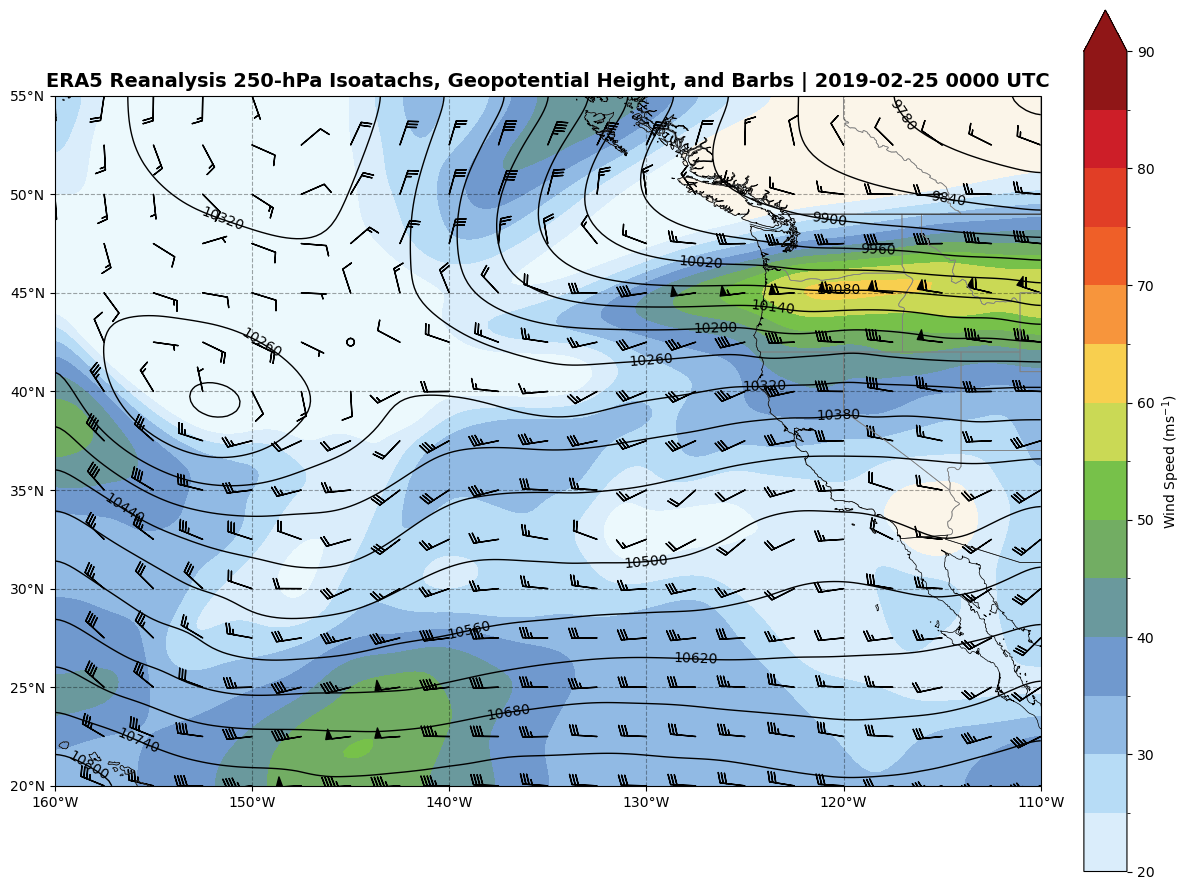

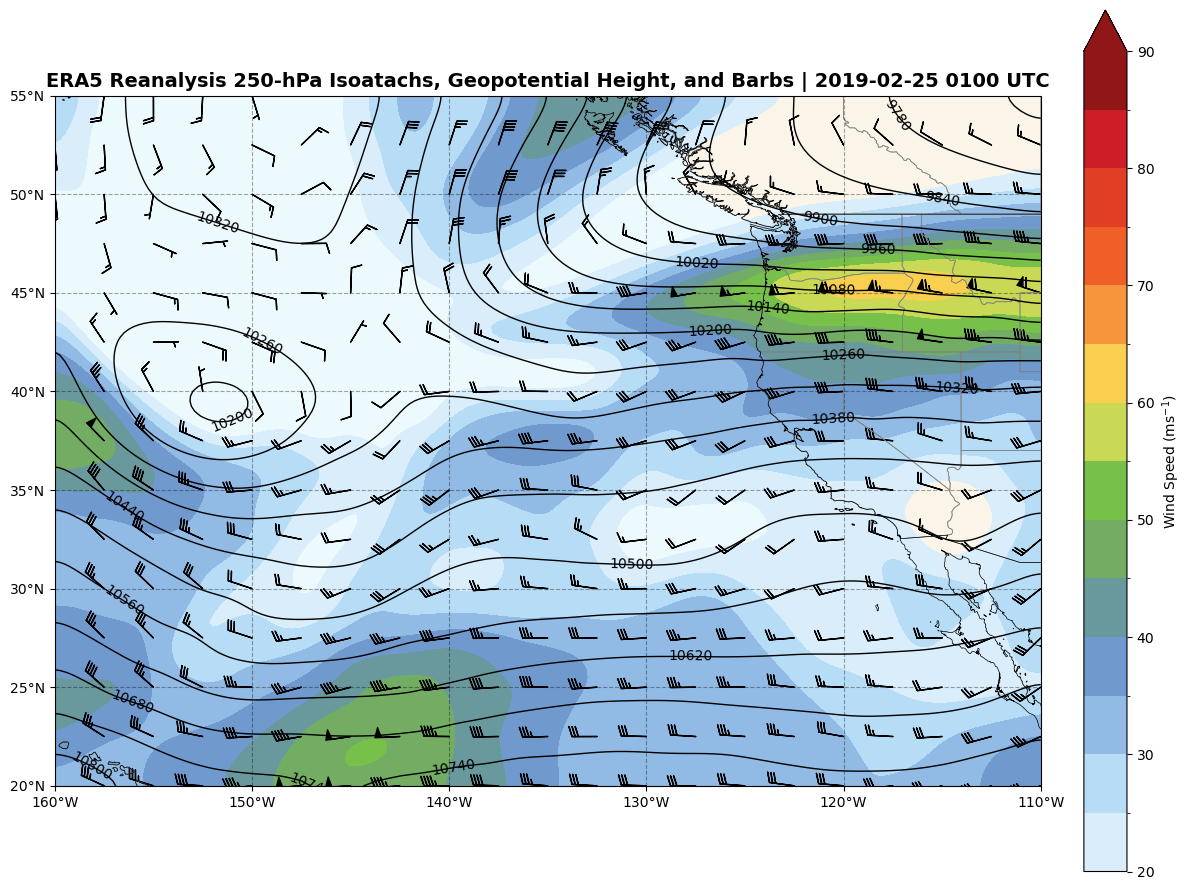

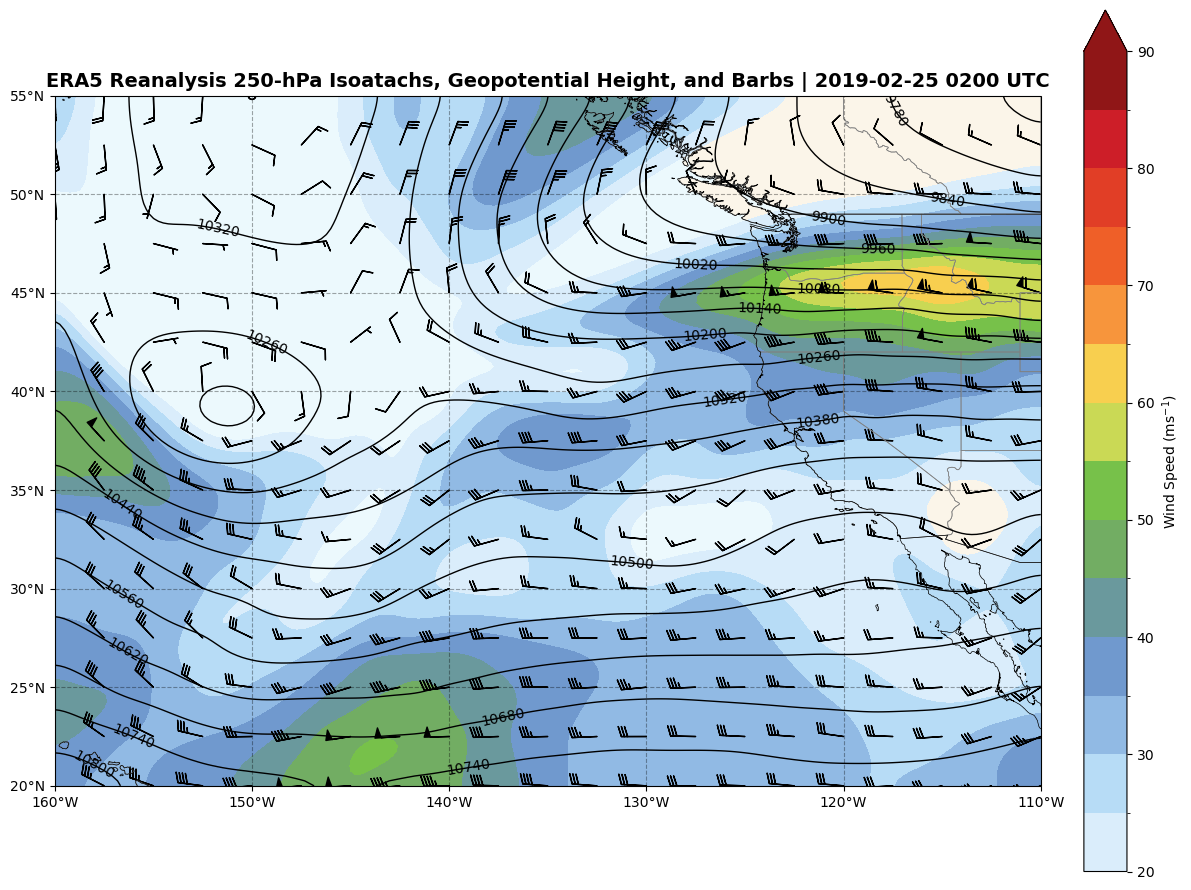

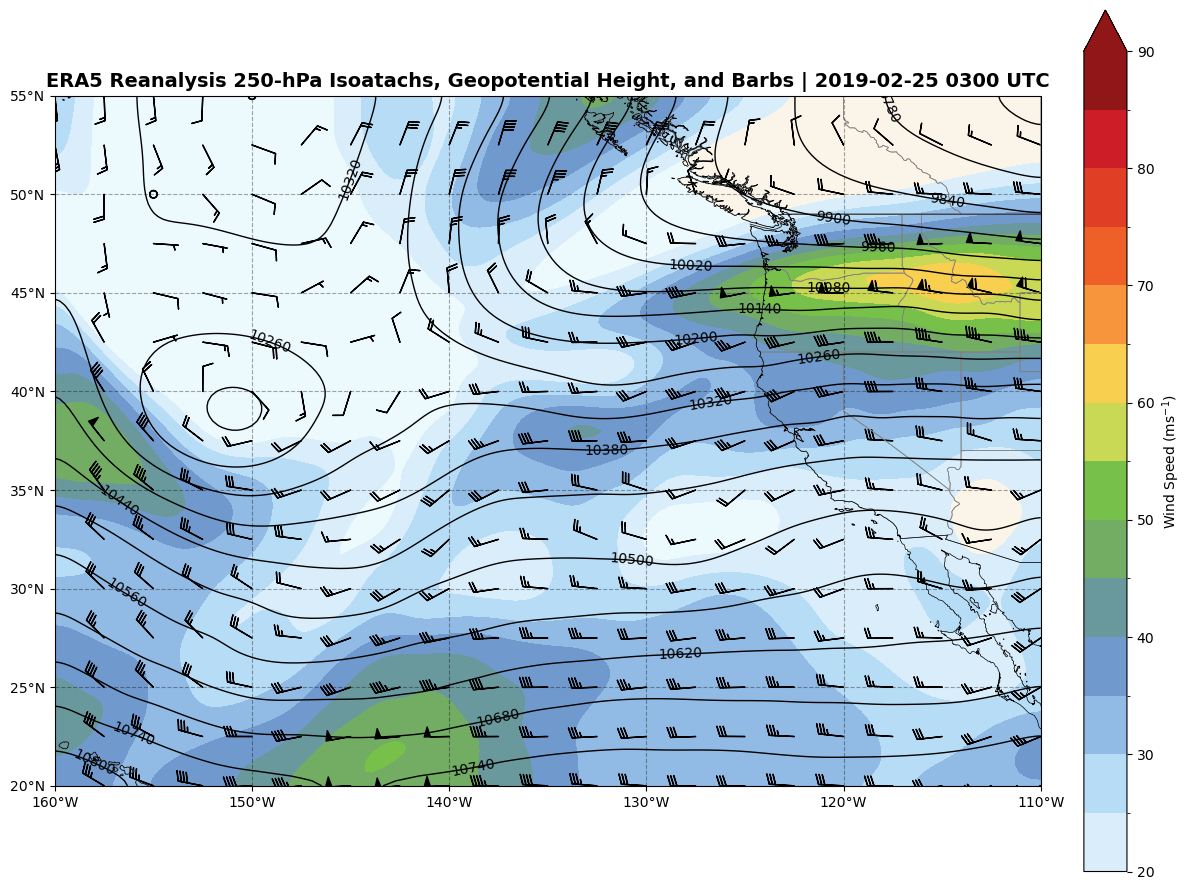

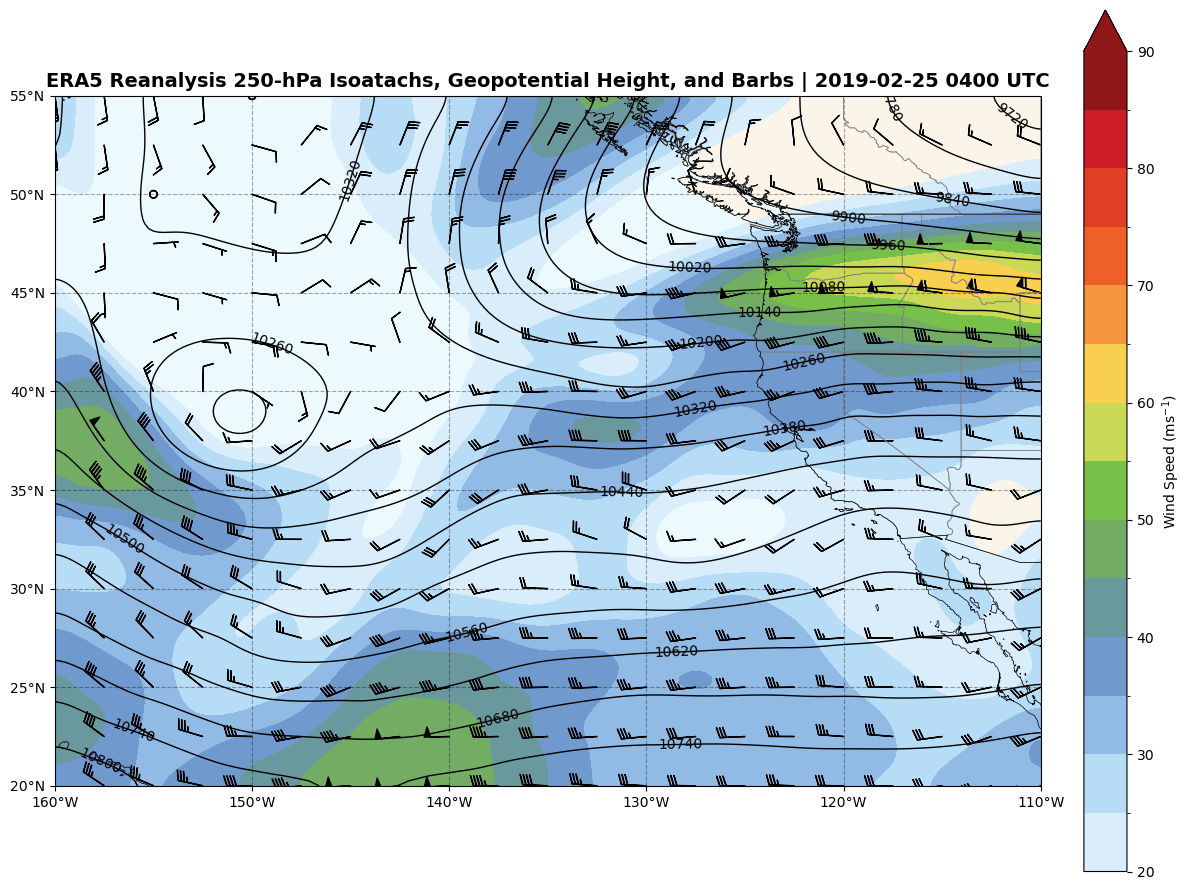

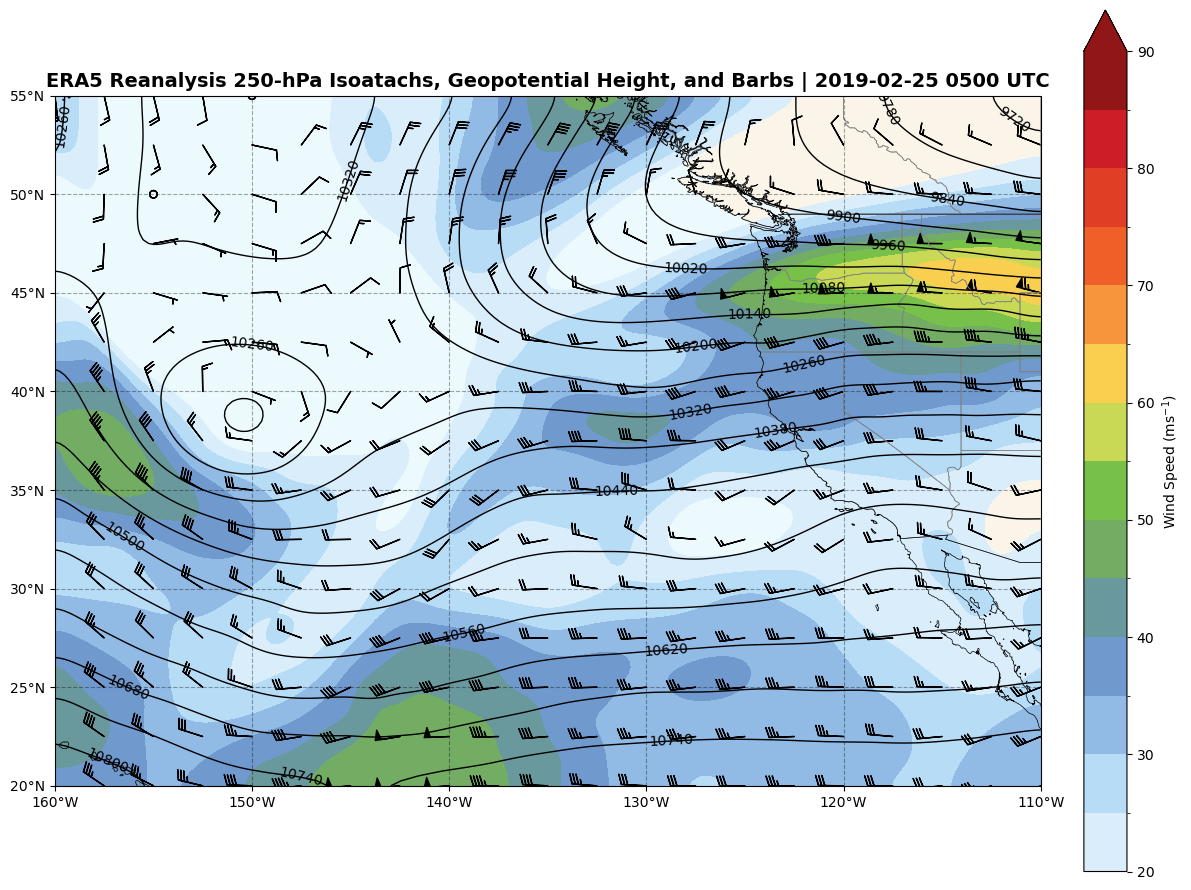

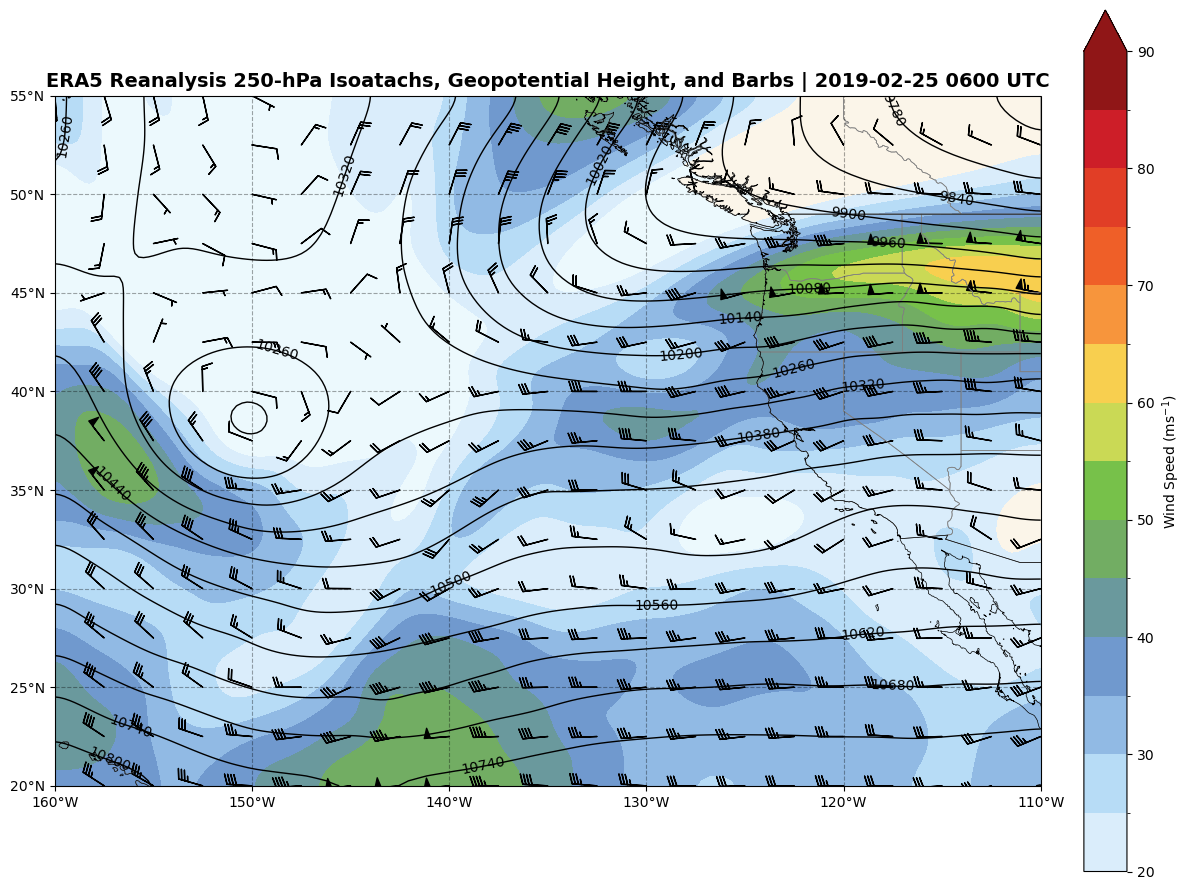

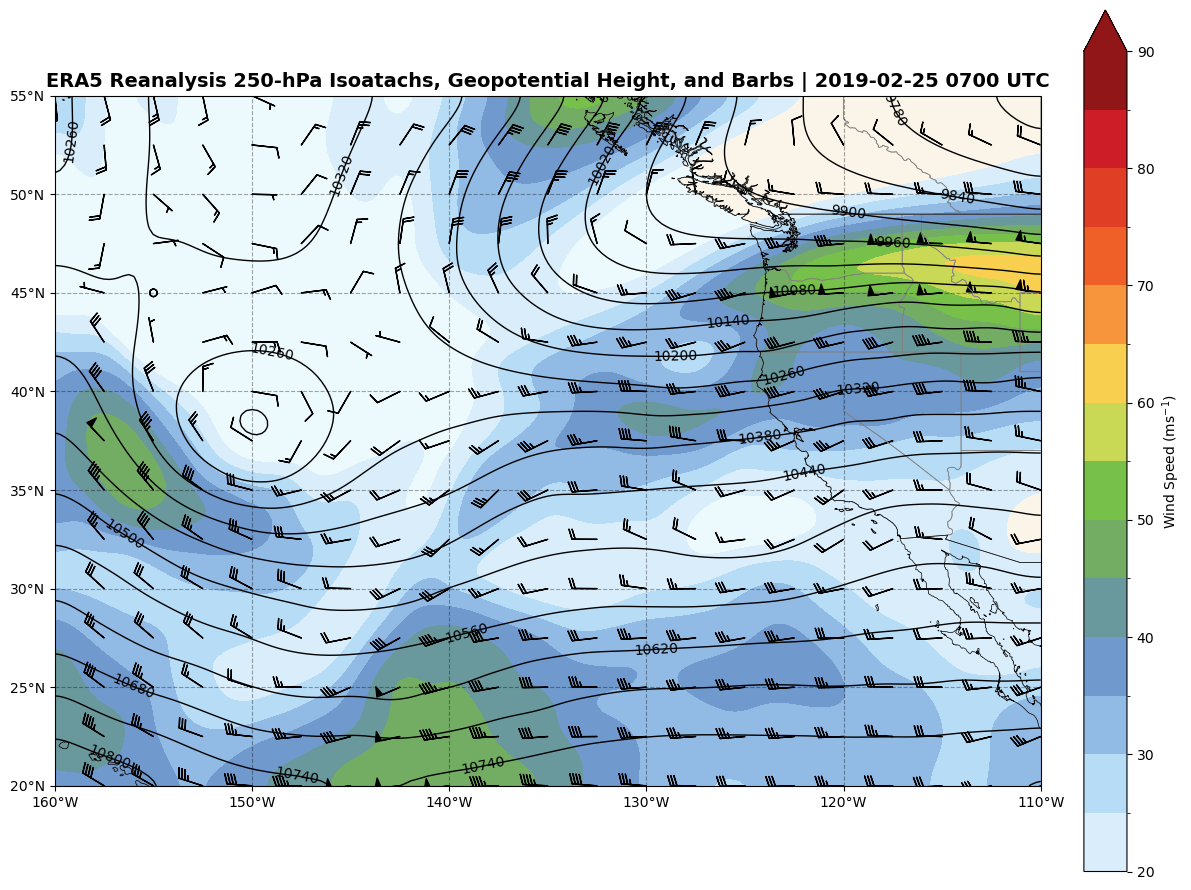

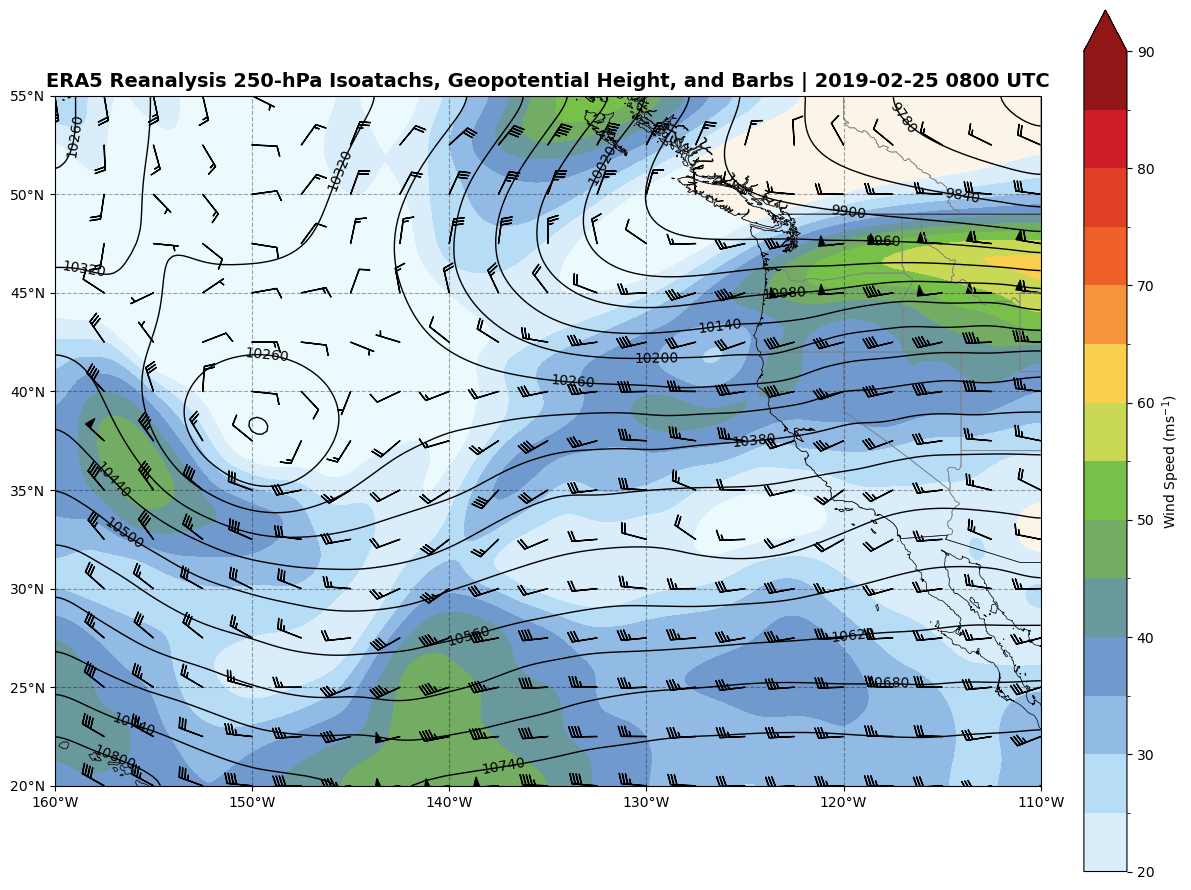

IndexError: index -1 is out of bounds for axis 0 with size 0

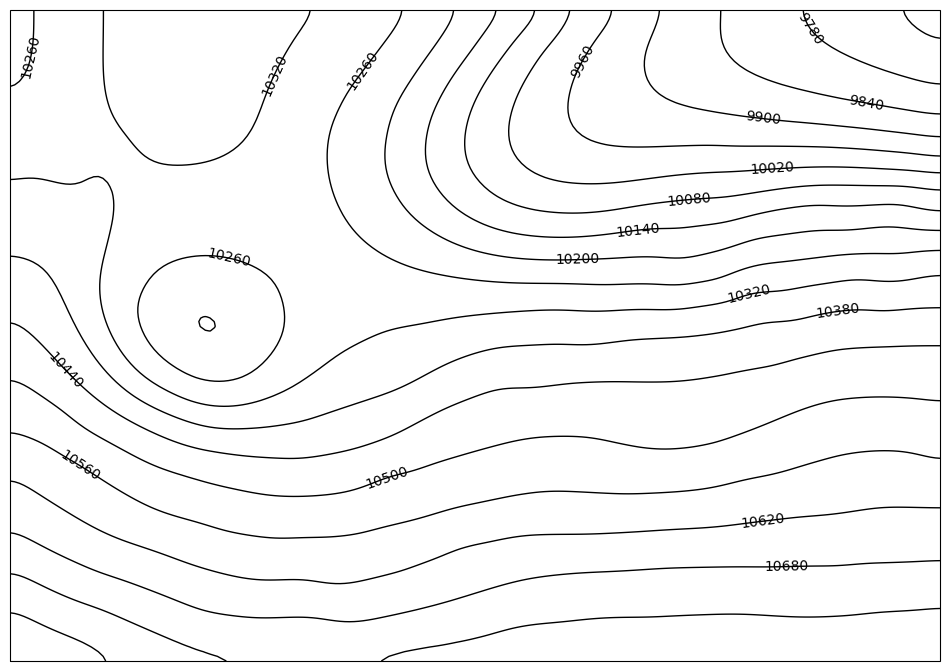

In [13]:
if __name__ == '__main__':
    directions = {'North': 55, 
                  'East': 250, 
                  'South': 20, 
                  'West': 200}
    g = 9.81 # units: m/s^2
    plot_250_isotachs(ds_pl, directions, g)